# Fashion classification with linear models
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We's see how well we can classify these with linear models. Let's start with looking at our data:

In [1]:
import warnings
import openml as oml
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from preamble import *
plt.rcParams["savefig.dpi"] = 100 # This controls the size of your figures

In [23]:
pd.set_option("display.max_columns", None)
plt.style.use("seaborn")
%matplotlib inline

In [5]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute); 
fmnist_classes = {
    0:"T-shirt/top",
    1: "Trouser",
    2: "Pullover", 
    3: "Dress", 
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt", 
    7: "Sneaker", 
    8: "Bag", 
    9: "Ankle boot"
}

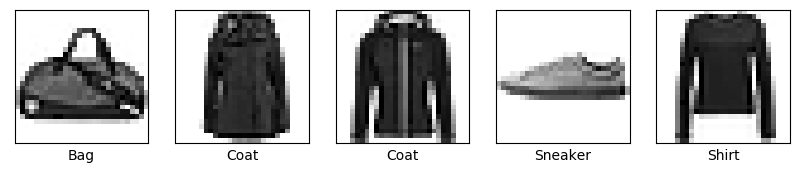

In [10]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))

for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
    
plt.show()

## Exercise 1: A quick benchmark
First, we'll try the default [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Linear SVMs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC). Click the links to read the documentation. We'll also compare it to [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead of  [`cross_val_scores`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

For now we are just interested in a quick approximation, so we don't use the full dataset for our experiments. Instead, we use 10% of our samples:

In [15]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

With this small sample of our data we can now train and evaluate the three classifiers.

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below the function you will find example output.

In [16]:
def evaluate_learners(classifiers, X, y):
    cross_validations = [cross_validate(model, X, y, return_train_score=True) for model in classifiers]

    return (
        list(map(lambda x: x["train_score"], cross_validations)),
        list(map(lambda x: x["test_score"], cross_validations))
    )

### Exercise 1.2
Call the function you created with a Logistic Regression, Linear SVM, and k-Nearest Neighbors Classifier.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [17]:
classifiers = [LogisticRegression(), KNeighborsClassifier(), LinearSVC()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

[array([0.922, 0.916, 0.916, 0.915, 0.922]),
 array([0.866, 0.862, 0.864, 0.866, 0.868]),
 array([0.961, 0.944, 0.94 , 0.955, 0.946])]

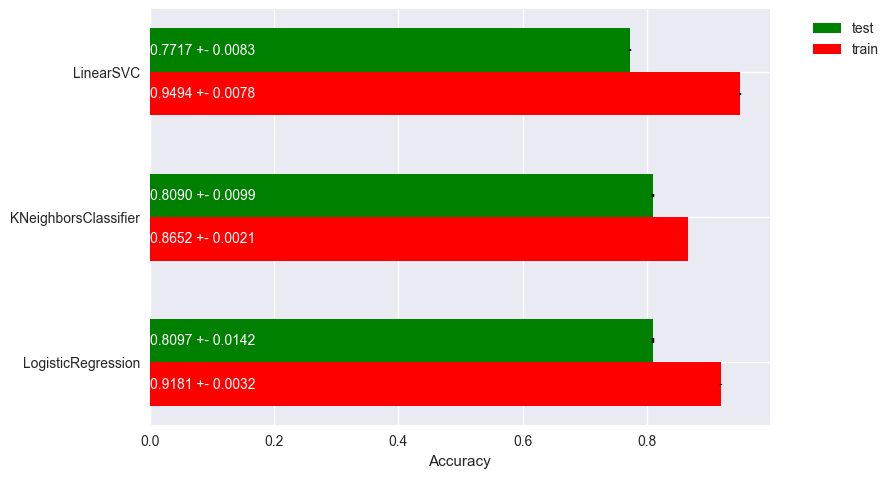

In [24]:
fig, ax = plt.subplots()
width=0.3

ax.barh(
    np.arange(len(train_scores)), 
    np.mean(test_scores, axis=1),
    width,
    yerr=np.std(test_scores, axis=1), 
    color='green', 
    label='test'
)
ax.barh(
    np.arange(len(train_scores))-width, 
    np.mean(train_scores, axis=1), 
    width,
    yerr= np.std(train_scores, axis=1), 
    color='red', 
    label='train'
)

for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
    
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best classifier? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

Logistic Regression and kNN showed the best performance. Linear SVC seems to be a little bit overfitted. To solve this we need to adjust hyperparameters.

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-10},10^{2}]$ and for n_neighbors between 1 and 100. C should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the regularization parameters in the range given above and, for each classifier, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each classifier. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.


In [29]:
from sklearn.model_selection import GridSearchCV

params = [
    {"C": np.logspace(-10, 2, num=10)},
    {"n_neighbors": np.geomspace(1, 100, num=10, dtype=int)[1:]},
    {"C": np.logspace(-10, 2, num=10)},
]

grid_searches = [
    GridSearchCV(model, param, return_train_score=True).fit(Xs, ys) 
    for model, param in zip(classifiers, params)
]

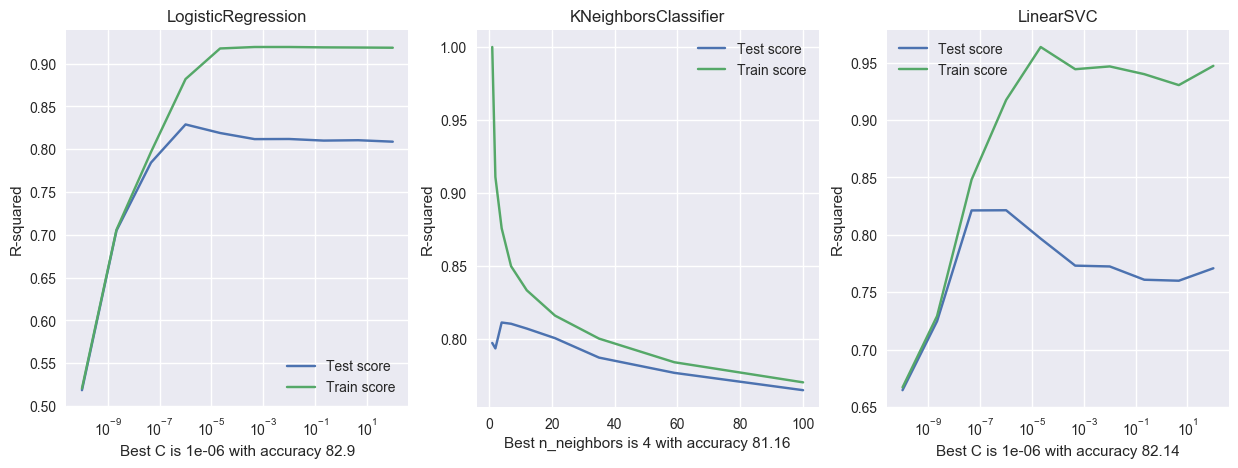

In [89]:
def plot_grids(gss, params):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    for gs, param, ax in zip(gss, params, axes):
        param_name = next(iter(param))
        ax.plot(gs.param_grid[param_name], gs.cv_results_['mean_test_score'], label = 'Test score')
        ax.plot(gs.param_grid[param_name], gs.cv_results_['mean_train_score'], label = 'Train score')
        ax.set_ylabel('R-squared')
        accuracy = np.round(gs.best_score_*100,2)
        ax.set_xlabel(f"Best {param_name} is {np.round(gs.best_params_[param_name], 6)} with accuracy {accuracy}")
        ax.set_title(gs.best_estimator_.__class__.__name__)
        ax.legend()

        if gs.best_estimator_.__class__.__name__ != "KNeighborsClassifier":
            ax.set_xscale('log')

plot_grids(grid_searches, params)

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

Logistic Regression: The best hyperparameter lays between 10^-7 and 10^-5, after that model is getting overfitted.

kNN: The best accuracy is stays when n_neighbors is around 4. When its greater 12 it loses accuracy.

LinearSVC: The best hyperparameter C lays between 10^-8 and 10^-6, after that model is getting strongly overfitted.

#### Lets try it again, but now, lets narrow down the interval of hyperparameters

In [86]:
params_2 = [
    {"C": np.linspace(10**-7, 10**-5, 5)},
    {"n_neighbors": np.arange(2, 10, 2)},
    {"C": np.linspace(10**-8, 10**-6, 5)},
]

grid_searches_2 = [
    GridSearchCV(model, param, return_train_score=True).fit(Xs, ys) 
    for model, param in zip(classifiers, params_2)
]

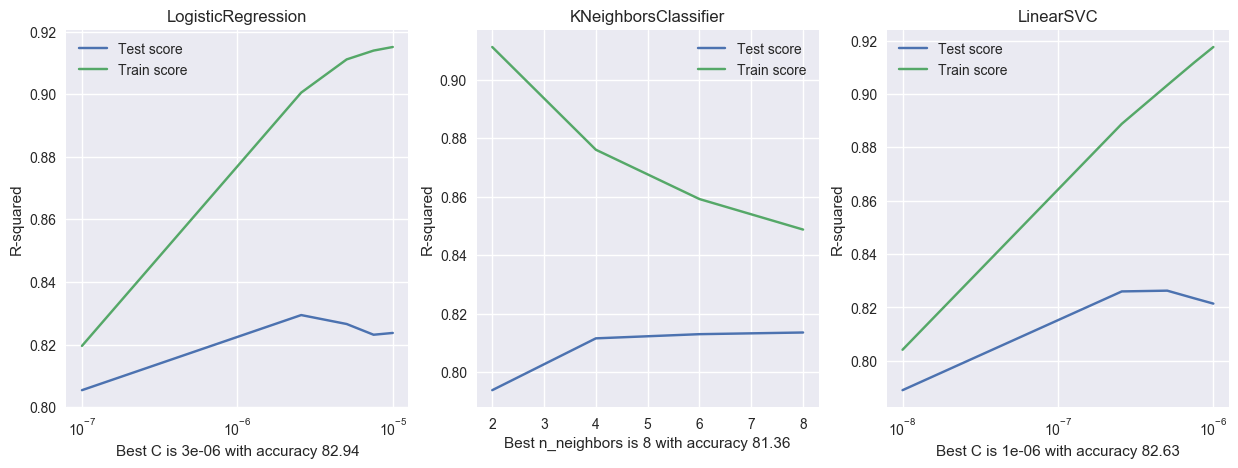

In [90]:
plot_grids(grid_searches_2, params_2)

## Exercise 3: Interpreting misclassifications
Chances are that your models are not yet perfect. It is important to understand what kind of errors it still makes. Let's take a closer look at which instances are misclassified and which classes are often confused.
Train the logistic regression model with `C=1e-6`. Train the model on a training set, and make predictions for a test set (both sets should be  sampled from our 10% subsample).

In [91]:
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

### Exercise 3.1
Train the classifier as described above, obtain the predictions `y_pred` on the test set, and identify all the misclassified samples `misclassified_samples`. Then, run the visualization code below to study the misclassifications

In [98]:
lr_classifier = LogisticRegression(C=1e-6)
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)

In [115]:
misclassified_samples = np.where(y_pred!= y_test)[0]

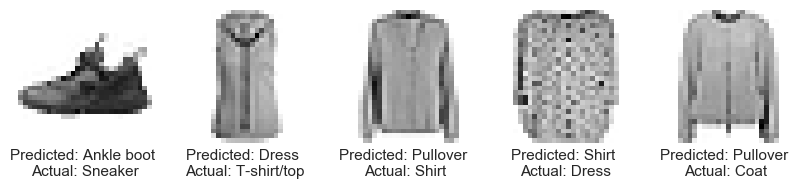

In [124]:
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test.values[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel(
        f"Predicted: {fmnist_classes[int(y_pred[i])]} \n"
        f"Actual: {fmnist_classes[int(y_test.values[i])]}",
    )
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show()

### Exercise 3.2
Interpret the results. Are these misclassifications to be expected? 

These missclassifications seem to be expected. I tried to categorize some of the results and can be "agree" with my model. For example, Looking at the second picture, I would say that it is actually dress, but actually it's categorized as "T-shirt/top".

### Exercise 3.3.
Run the code below on your results to draw the complete confusion matrix and get more insight on the systematic misclassifications 
of your model. A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results. 
Does your model produce certain types of error more often than other types? 

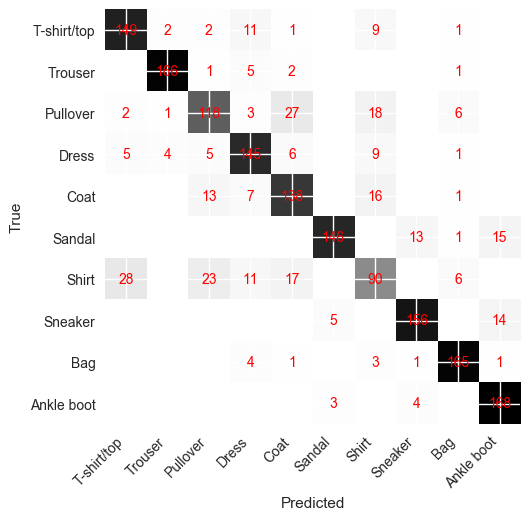

In [198]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

def plot_conf_matrix(cm, scale=None):
    fig, ax = plt.subplots()
    cm_scaled = None
    if scale:
        cm_scaled = cm.copy()
        cm_scaled[cm_scaled < cm_scaled.max() / 3] = cm_scaled[cm_scaled < cm_scaled.max() / 3] * scale
        
    if cm_scaled is None:
        im = ax.imshow(cm)
    else:
        im = ax.imshow(cm_scaled)
        
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
    ax.set_yticklabels(list(fmnist_classes.values()))
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

    for i in range(100):
        if  cm[i%10,int(i/10)]:
            ax.text(int(i/10), i%10, cm[i%10,int(i/10)], ha="center", va="center", color="red")
            
plot_conf_matrix(cm)

Because the number are not clearly visible I decided to hyperbolize confusion matrix colors a little bit:

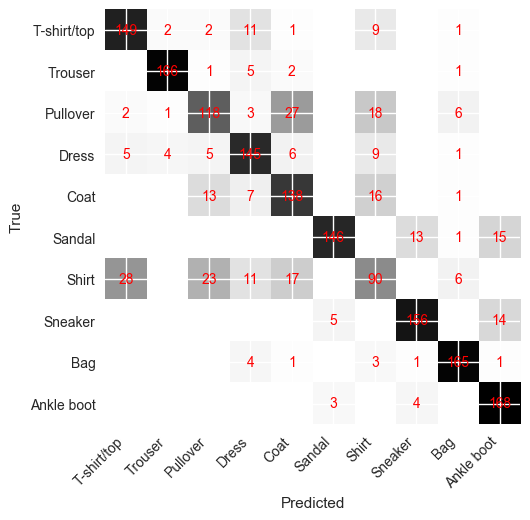

In [199]:
plot_conf_matrix(cm, scale=3)

According to confusion matrix, ML algorithm missclasified the most the folowwing types:
* Shirt and T-Shirt/top   < ----- > This is the most missclassified type
* Shirt and Pullover
* Shirt and Coat
* Shirt and Dress
* T-shirt/top and Dress
* Ankle boot and Sandal
* Ankle boot and Sneaker

## Exercise 4: Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Exercise 4.1
Train a Logistic Regression model and a Linear SVM using their tuned hyperparameters from exercise 2. 
When in doubt, use `C=1e-7` for LogReg and `C=1e-8` for the SVM. 
Pass the trained model to the provided plotting function. Interpret the results in detail. 
Why do you get multiple plots per model? What do the features represent in your data. 
Does it seems like the models pay attention to the right features?
Do you models seem to ignore certain features? Do you observe differences in quality between the different classes? Do you observe any differences between the models?

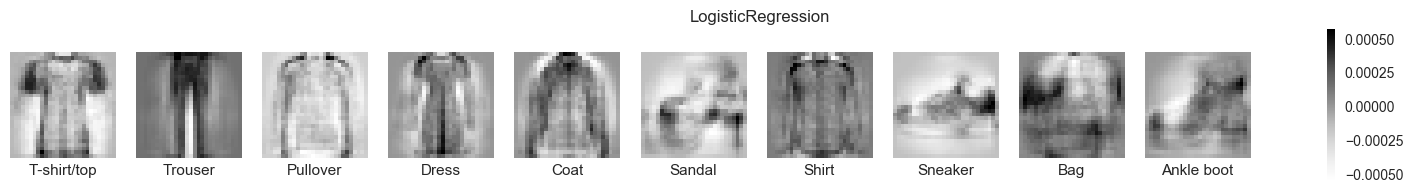

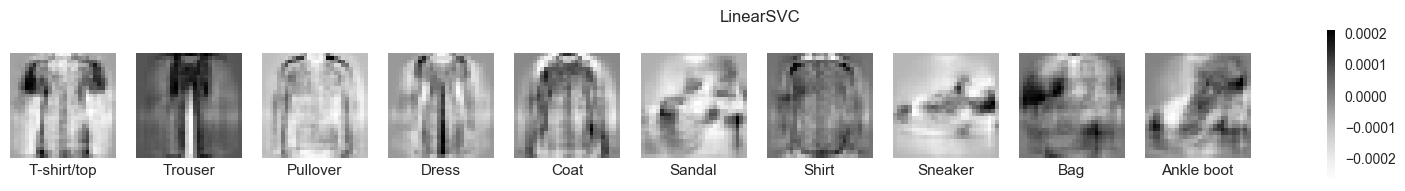

In [242]:
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name or model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())


lr_model = LogisticRegression(C=1e-7)
svc_model = LinearSVC(C=1e-8)

lr_model.fit(Xs, ys)
svc_model.fit(Xs, ys)

plot_coefficients(lr_model)
plot_coefficients(svc_model)

1. I got various plots per model as each plot represent a cloth type. They correspond to target types.
2. Pixels of the images are represented by features.
3. Models pay attention to the right features, specially LogisticRegression.
4. By observing different plots I notice that sneaker and anckle boot seem the same, also Shirt, Coat, Dress, Pullover and T-shirt/top seem to be pretty much the same, but looking at the previous question it could explain why I got those values in the confusion matrix.
5. There is difference in the quality between different classes: Sandal is hardly to understand and sneaker is easy.
6. LinearSVM is much same as LogisticRegression.

### Exercise 4.2
Repeat the previous exercise, but now only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot. Interpret and explain the results.

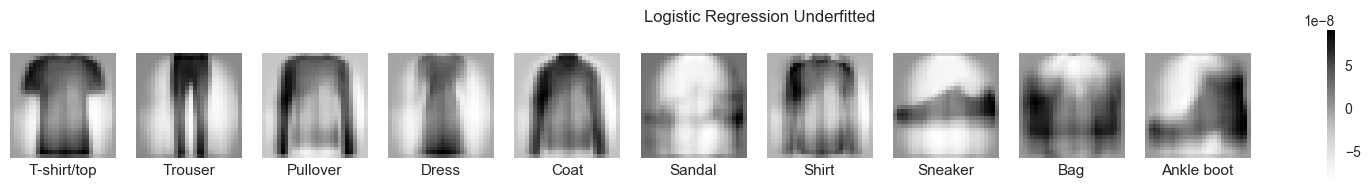

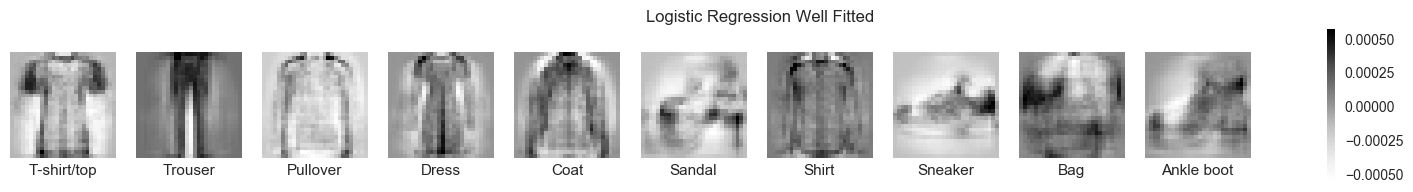

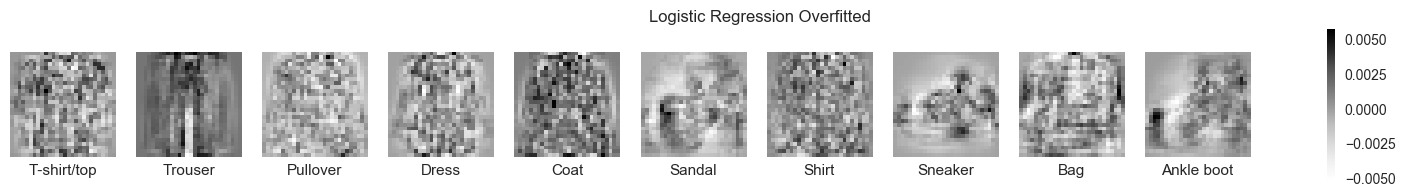

In [243]:
lr_underfitted = LogisticRegression(C=10**-12)
lr_overfitted = LogisticRegression(C=10**-2)

lr_underfitted.fit(Xs, ys)
lr_overfitted.fit(Xs, ys)

plot_coefficients(lr_underfitted, name="Logistic Regression Underfitted")
plot_coefficients(lr_model, name="Logistic Regression Well Fitted")
plot_coefficients(lr_overfitted, name="Logistic Regression Overfitted")

It can be seen that when the model is overfitted as it is harder to recognize the shapes, but it is more difficult to understand distinction between underfitted and well fitted models:

Pictures are good either on underfitted and overfitted, but the underfitted model got covered with shapes of different classes: Underfitted Sandal is covered by Shirt, while Shirt is covered with a Sneaker ans so on.

Pictures of overfitted model is really hard to be recognized by a human-eye.